Name: Sunay Sanghani
USC ID: 5373536322
github username: @sunaysanghani

In [405]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
from sklearn.utils import resample
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [406]:
folder_path = "C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data"
def split_train_test(root):
    train = []
    test = []
    for root, directory, file in os.walk(root):
        for f in file:
            if 'pdf' not in f:
                new_name = os.path.join(root, f)
                if 'bending1' in new_name or 'bending2' in new_name:
                    if 'dataset1.csv' in new_name or 'dataset2.csv' in new_name:
                        test.append(new_name)
                    else:
                        train.append(new_name)
                else:
                    if 'dataset1.csv' in new_name or 'dataset2.csv' in new_name or 'dataset3.csv' in new_name:
                        test.append(new_name)
                    else:
                        train.append(new_name)
    return train, test

In [407]:
train, test = split_train_test(folder_path)

In [408]:
train

['C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending1\\dataset3.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending1\\dataset4.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending1\\dataset5.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending1\\dataset6.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending1\\dataset7.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending2\\dataset3.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending2\\dataset4.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending2\\dataset5.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending2\\dataset6.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\cycling\\dataset10.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\cycling\\dataset11.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\cycling\\dataset12.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data

In [409]:
test

['C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending1\\dataset1.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending1\\dataset2.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending2\\dataset1.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\bending2\\dataset2.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\cycling\\dataset1.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\cycling\\dataset2.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\cycling\\dataset3.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\lying\\dataset1.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\lying\\dataset2.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\lying\\dataset3.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\sitting\\dataset1.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\sitting\\dataset2.csv',
 'C:/Users/sunay/Downloads/DSCI552HW4/data/Arem_data\\sitting\\dat

# 1c. Feature Extraction

Research what types of time-domain features are usually used in time series
classification and list them (examples are minimum, maximum, mean, etc).

1. Date time features
2. mean
3. minimum
4. standard deviation
5. first quartile
6. third quartile
7. distribution
8. correlation graphs

# 1(c)(ii). Extract 

In [410]:
columns_to_measure = ['min', 'max', 'mean', 'median', 'std', 'first_q', 'third_q']
columns_df = [col + str(i) for i in range(1,7) for col in columns_to_measure]
sniffer = csv.Sniffer()

params = ['min', 'max', 'mean', 'std', '25%', '50%', '75%']
extract_data = []
def get_path_for_file(file):
    directory = os.path.dirname(file)
    components = os.path.dirname(file).split("/")
    return components[-1]

def _separator(file):
    f = open(file)
    return sniffer.sniff(f.read()).delimiter

def get_columns(segs=1):
    end = 6 * segs + 1
    feature = []
    for i in range(1, end):
        for stat in columns_to_measure:
            feature.append(f'{stat}{i}')
    return feature

def load_Data(files, features, cols, segs=1, standard=False):
    instances = []
    labels = []
    for f in files:
        labels.append(get_path_for_file(f))
        separator = _separator(f)
        if separator == ",":
            new_file = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')
        else:
            new_file = pd.read_csv(f, skiprows=5,sep="\\s+", header=None, on_bad_lines='skip')
        new_file.columns = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]

        
        segments = int(new_file.shape[0] / segs)
        description = []
        for i in range(segs):
            start_length = i * segments
            end_length= min((i+1) * segments, new_file.shape[0])
            current_segment = new_file[start_length : end_length]
            time_column = "# Columns: time"
            current_description = current_segment.describe().drop('count').drop(columns=time_column).T
            description.append(current_description.values.flatten())
        instances.append(np.concatenate(description))
    feature_df = pd.DataFrame(instances)
    feature_df.columns = get_columns(segs)
    feature_df = feature_df.loc[:, features]
    
    feature_df['label'] = pd.Series(labels)
    
    return feature_df

In [411]:
features = [f'{stat}{i}' for i in range(1,7) for stat in columns_to_measure]

In [412]:
train_data = load_Data(train, features, columns_to_measure)
test_data = load_Data(test, features, columns_to_measure)

In [413]:
train_data

,min1,max1,mean1,median1,std1,first_q1,third_q1,min2,max2,mean2,...,first_q5,third_q5,min6,max6,mean6,median6,std6,first_q6,third_q6,label
0,43.954500,1.558835,35.00,43.00,44.330,45.0000,47.40,0.426250,0.338690,0.0,...,36.50,38.50,0.493292,0.513506,0.0,0.00,0.430,0.9400,1.79,Arem_data\bending1
1,42.179813,3.670666,33.00,39.15,43.500,45.0000,47.75,0.696042,0.630860,0.0,...,36.33,38.67,0.613521,0.524317,0.0,0.00,0.500,1.0000,2.18,Arem_data\bending1
2,41.678063,2.243490,33.00,41.33,41.750,42.7500,45.75,0.535979,0.405469,0.0,...,31.25,37.50,0.383292,0.389164,0.0,0.00,0.430,0.5000,1.79,Arem_data\bending1
3,43.454958,1.386098,37.00,42.50,43.250,45.0000,48.00,0.378083,0.315566,0.0,...,24.00,33.50,0.679646,0.622534,0.0,0.43,0.500,0.8700,5.26,Arem_data\bending1
4,43.969125,1.618364,36.25,43.31,44.500,44.6700,48.00,0.413125,0.263111,0.0,...,23.75,30.75,0.555313,0.487826,0.0,0.00,0.490,0.8300,2.96,Arem_data\bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,34.763333,4.742208,20.75,31.67,35.290,38.2500,46.25,4.223792,2.278004,0.0,...,18.33,25.50,3.288271,1.647528,0.0,2.05,3.270,4.3050,9.39,Arem_data\walking
65,34.935813,4.645944,21.50,32.00,35.500,38.0625,51.00,4.115750,2.335243,0.0,...,18.25,25.00,3.280021,1.700918,0.0,2.12,3.015,4.5000,10.21,Arem_data\walking
66,34.333042,4.948770,18.33,31.25,34.750,38.0000,47.67,4.396958,2.568680,0.0,...,18.00,24.00,3.261583,1.617290,0.0,2.05,2.980,4.3200,8.01,Arem_data\walking
67,34.599875,4.731790,18.33,31.50,35.125,38.0000,45.75,4.398833,2.538521,0.0,...,18.25,23.25,3.289542,1.680170,0.0,2.12,3.015,4.2600,8.86,Arem_data\walking


In [414]:
test_data

,min1,max1,mean1,median1,std1,first_q1,third_q1,min2,max2,mean2,...,first_q5,third_q5,min6,max6,mean6,median6,std6,first_q6,third_q6,label
0,40.624792,1.476967,37.25,39.2500,40.500,42.0000,45.00,0.358604,0.322605,0.0,...,36.0000,38.25,0.570583,0.582915,0.0,0.0000,0.430,1.300,1.92,Arem_data\bending1
1,42.812812,1.435550,38.00,42.0000,42.500,43.6700,45.67,0.372438,0.289158,0.0,...,34.5000,38.50,0.571083,0.601010,0.0,0.0000,0.430,1.300,3.11,Arem_data\bending1
2,24.562958,3.737514,12.75,23.1875,24.250,26.5000,51.00,0.590833,0.837408,0.0,...,27.0000,30.00,0.700188,0.693720,0.0,0.4300,0.500,0.870,4.97,Arem_data\bending2
3,27.464604,3.583582,0.00,25.5000,28.000,30.0000,42.75,0.449708,0.767197,0.0,...,20.7500,33.00,1.122125,1.012342,0.0,0.4700,0.830,1.300,6.76,Arem_data\bending2
4,37.177042,3.581301,24.25,34.5000,36.250,40.2500,45.00,2.374208,1.601799,0.0,...,21.7500,25.50,2.921729,1.852600,0.0,1.5000,2.500,3.900,9.34,Arem_data\cycling
5,37.561188,3.226507,28.75,35.2500,36.875,40.2500,44.75,2.080688,1.639258,0.0,...,21.5000,24.33,2.765896,1.769203,0.0,1.4100,2.450,3.770,9.62,Arem_data\cycling
6,37.058708,3.710180,22.00,34.5000,36.000,40.0625,44.67,2.438146,1.996887,0.0,...,21.0000,24.25,2.983750,1.815730,0.0,1.5000,2.570,4.150,8.55,Arem_data\cycling
7,27.716375,1.442253,23.50,27.0000,27.500,29.0000,30.00,0.363688,0.394817,0.0,...,10.7500,21.00,0.734271,0.613688,0.0,0.4300,0.710,1.000,4.50,Arem_data\lying
8,44.182937,7.495615,24.75,48.0000,48.000,48.0000,48.33,0.101875,0.346756,0.0,...,5.5425,12.75,0.692771,0.675781,0.0,0.3225,0.500,0.940,3.91,Arem_data\lying
9,48.004167,0.032038,48.00,48.0000,48.000,48.0000,48.25,0.007167,0.055106,0.0,...,10.0000,12.00,0.641229,0.388372,0.0,0.4600,0.500,0.830,2.50,Arem_data\lying


In [415]:
train_data.describe().loc['std']

min1        4.917692
max1        1.758670
mean1       8.794295
median1     5.731647
std1        4.956111
first_q1    4.783645
third_q1    4.429182
min2        1.600701
max2        0.902808
mean2       0.000000
median2     0.952201
std2        1.436960
first_q2    2.158416
third_q2    5.147841
min3        3.863097
max3        0.995959
mean3       3.053869
median3     4.145255
std3        3.845730
first_q3    3.946023
third_q3    4.759853
min4        1.179861
max4        0.473576
mean4       0.000000
median4     0.842501
std4        1.150092
first_q4    1.566564
third_q4    2.302408
min5        5.120426
max5        1.057998
mean5       5.368786
median5     5.543882
std5        5.267414
first_q5    4.957231
third_q5    5.449726
min6        1.171401
max6        0.519420
mean6       0.051766
median6     0.774358
std6        1.104626
first_q6    1.550393
third_q6    2.540166
Name: std, dtype: float64

In [416]:
test_data.describe().loc['std']

min1         6.790086
max1         1.869285
mean1       12.136206
median1      7.673052
std1         7.088085
first_q1     6.385720
third_q1     4.379342
min2         1.500529
max2         0.832472
mean2        0.000000
median2      0.941307
std2         1.345903
first_q2     2.028482
third_q2     4.870395
min3         4.588252
max3         0.760779
mean3        2.644618
median3      4.554121
std3         4.753522
first_q3     5.014339
third_q3     5.393220
min4         1.146338
max4         0.409008
mean4        0.000000
median4      0.867088
std4         1.161705
first_q4     1.541943
third_q4     1.733937
min5         7.366781
max5         0.919274
mean5        8.252947
median5      7.823870
std5         7.438749
first_q5     7.259433
third_q5     6.782153
min6         1.119410
max6         0.525263
mean6        0.000000
median6      0.711956
std6         1.037811
first_q6     1.461470
third_q6     2.505306
Name: std, dtype: float64

In [417]:
sampled_std = pd.DataFrame([resample(train_data.iloc[:, :-1]).std() for _ in range(1000)])

interval = sampled_std.quantile([0.05, 0.95])

interval = interval.round(2)

interval = interval.T.rename(columns={0.05: 'lower bound', 0.95: 'higher bound'})

print(interval)

          lower bound  higher bound
min1             4.33          5.42
max1             1.55          1.96
mean1            7.53          9.95
median1          5.16          6.19
std1             4.34          5.47
first_q1         3.94          5.52
third_q1         3.30          5.49
min2             1.42          1.74
max2             0.81          0.96
mean2            0.00          0.00
median2          0.83          1.04
std2             1.25          1.57
first_q2         1.92          2.33
third_q2         4.65          5.54
min3             3.20          4.43
max3             0.79          1.20
mean3            2.83          3.22
median3          3.44          4.72
std3             3.17          4.43
first_q3         3.30          4.53
third_q3         4.04          5.42
min4             1.08          1.24
max4             0.43          0.50
mean4            0.00          0.00
median4          0.76          0.89
std4             1.05          1.21
first_q4         1.43       

# 1iv. Use your judgement to select the three most important time-domain features

1. Mean is a good indicator for time because it has the ability to get a central value when the data distribution is c
2. Median is another good indicator for the data since if it has too many outliers it can get the central value and not get too skewed away from the mean. Median could be a good feature because it does not get as affected by such outliers.
3. Standard Deviation is a good indicator as well for time because it can help us understand the distribution of the data and identify how far away the distribution is away from the mean.

# 2. ISLR 3.7.4

# (a)

Overarching concept is that the smaller the RSS, the better the fit of the model. The cubic model which has more predictors would have a lower RSS compared to a linear regression. Cubic regression has more predictors and has a better fit on the model which would make its RSS better and lower.

# (b)

The testing RSS for cubic regression would be higher than a regular linear regression. The cubic regression has more predictors which leads to overfitting. In the test case, linear regression has a better fit on the data and it's RSS is lower.

# c)

We would expect the RSS for the cubic regression to be less since it still has more predictors. The linear regression will now start to underfit the data, while the cubic regression has more flexibility.

# d)

Unable to answer this since the answer depends on which regression is closer to the actual answer.

# Start of HW4 and Use of Binary Classification Using Logistic Regression

# 2a. i)

In [418]:
def get_cols(indexes, props):
    cols = [f"{prop}{index}" for index in indexes for prop in props]
    return cols

def get_labeled_cols(df, cols):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[temp != 1, 'label'] = 0
    return cols + ['label']

def plot_scatter_plot(df, hue_value):  #maybe can remove this method altogether
    sns.pairplot(df, hue=hue_value)
    plt.show()

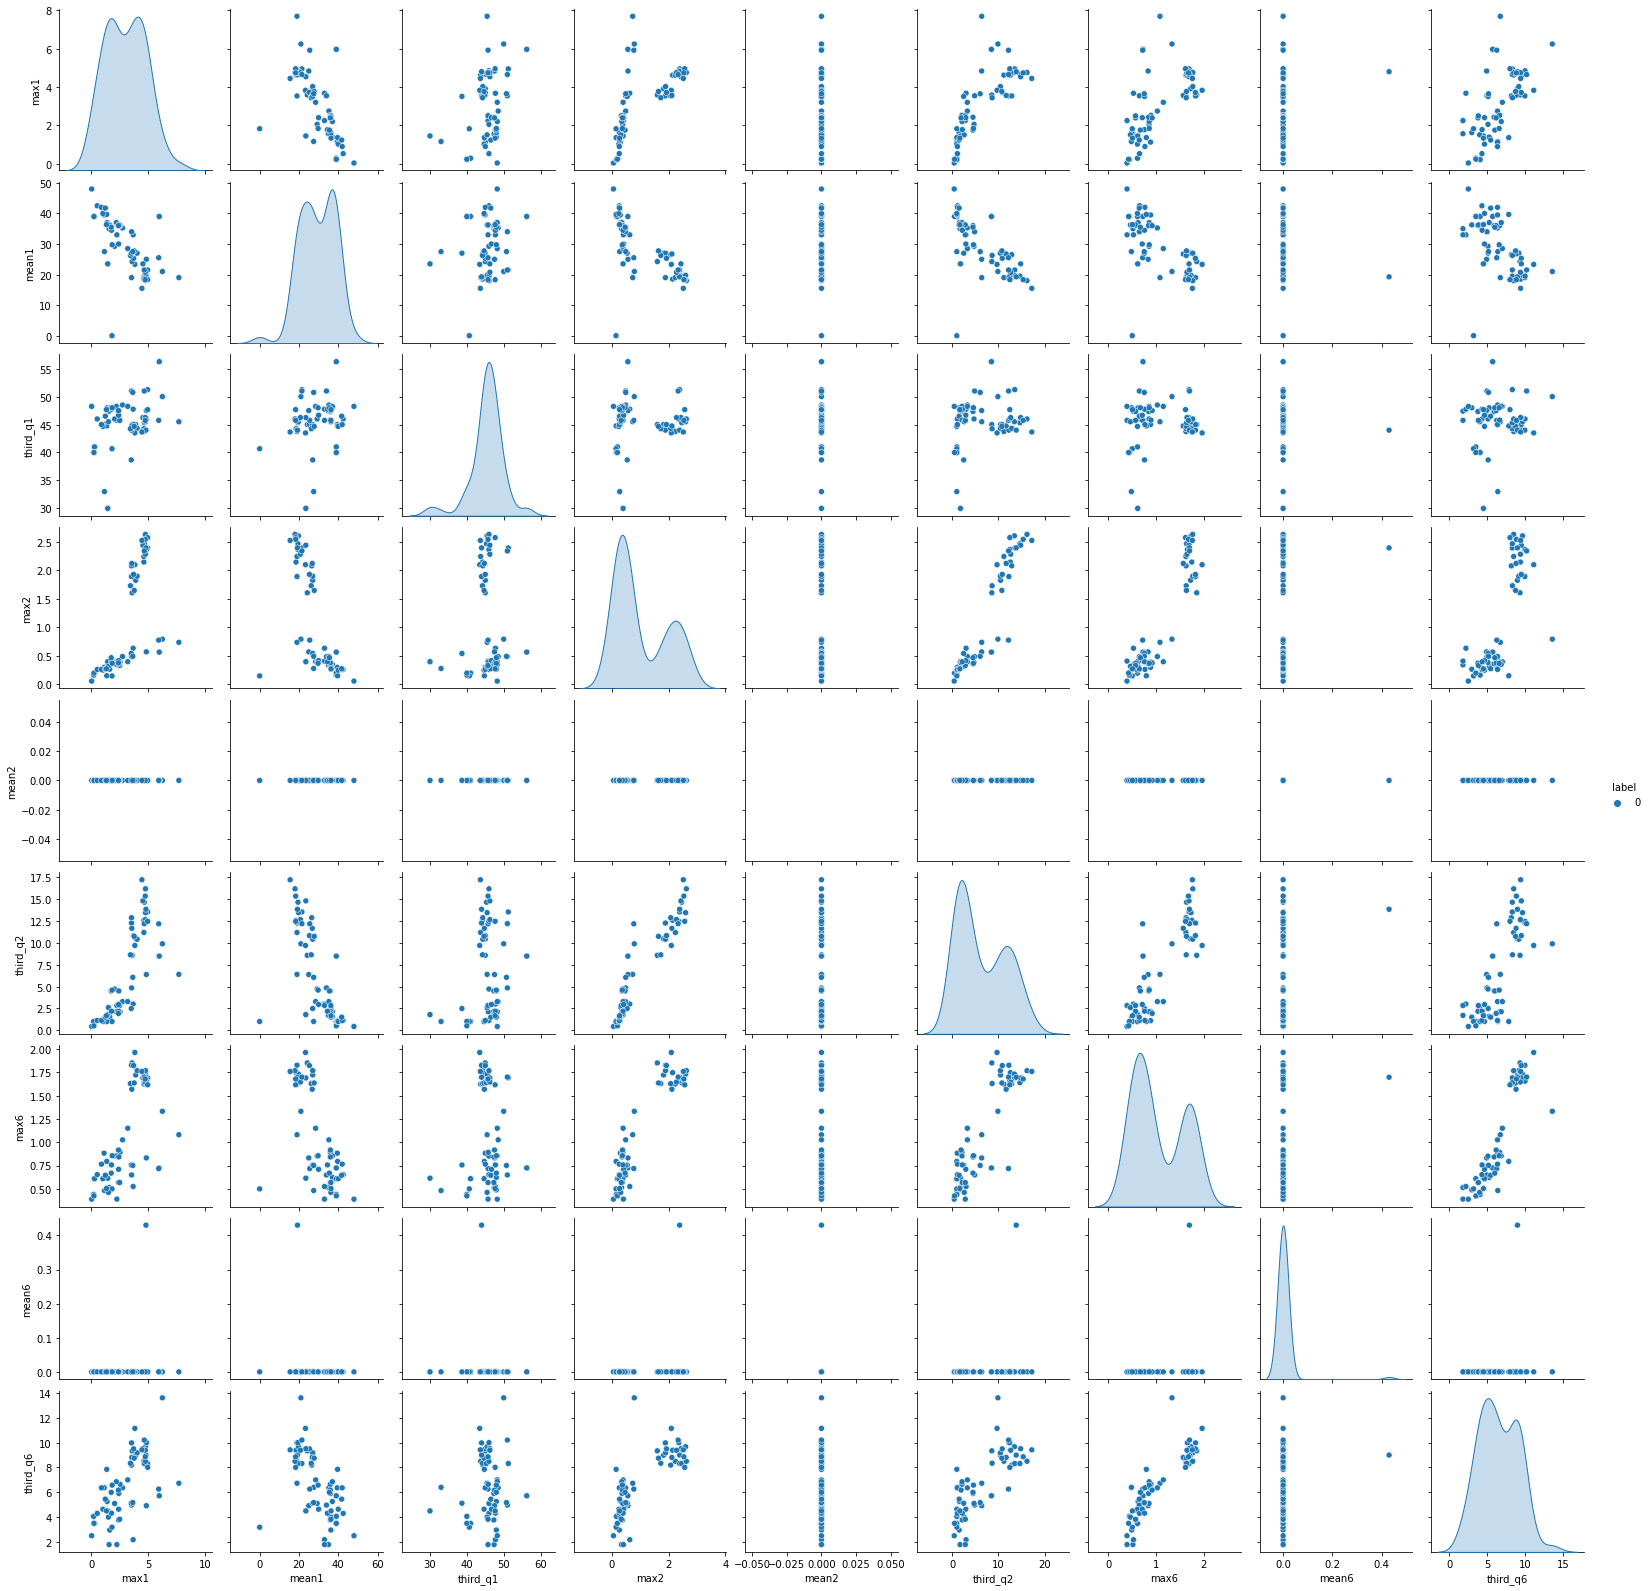

In [419]:
relevant_columns = get_cols([1, 2, 6], ['max', 'mean', 'third_q'])
relevant_columns_labeled = get_labeled_cols(train_data, relevant_columns)
relevant_df = train_data[relevant_columns_labeled]
plot_scatter_plot(relevant_df, 'label')

In [420]:
train_data

,min1,max1,mean1,median1,std1,first_q1,third_q1,min2,max2,mean2,...,first_q5,third_q5,min6,max6,mean6,median6,std6,first_q6,third_q6,label
0,43.954500,1.558835,35.00,43.00,44.330,45.0000,47.40,0.426250,0.338690,0.0,...,36.50,38.50,0.493292,0.513506,0.0,0.00,0.430,0.9400,1.79,0
1,42.179813,3.670666,33.00,39.15,43.500,45.0000,47.75,0.696042,0.630860,0.0,...,36.33,38.67,0.613521,0.524317,0.0,0.00,0.500,1.0000,2.18,0
2,41.678063,2.243490,33.00,41.33,41.750,42.7500,45.75,0.535979,0.405469,0.0,...,31.25,37.50,0.383292,0.389164,0.0,0.00,0.430,0.5000,1.79,0
3,43.454958,1.386098,37.00,42.50,43.250,45.0000,48.00,0.378083,0.315566,0.0,...,24.00,33.50,0.679646,0.622534,0.0,0.43,0.500,0.8700,5.26,0
4,43.969125,1.618364,36.25,43.31,44.500,44.6700,48.00,0.413125,0.263111,0.0,...,23.75,30.75,0.555313,0.487826,0.0,0.00,0.490,0.8300,2.96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,34.763333,4.742208,20.75,31.67,35.290,38.2500,46.25,4.223792,2.278004,0.0,...,18.33,25.50,3.288271,1.647528,0.0,2.05,3.270,4.3050,9.39,0
65,34.935813,4.645944,21.50,32.00,35.500,38.0625,51.00,4.115750,2.335243,0.0,...,18.25,25.00,3.280021,1.700918,0.0,2.12,3.015,4.5000,10.21,0
66,34.333042,4.948770,18.33,31.25,34.750,38.0000,47.67,4.396958,2.568680,0.0,...,18.00,24.00,3.261583,1.617290,0.0,2.05,2.980,4.3200,8.01,0
67,34.599875,4.731790,18.33,31.50,35.125,38.0000,45.75,4.398833,2.538521,0.0,...,18.25,23.25,3.289542,1.680170,0.0,2.12,3.015,4.2600,8.86,0


# 2aii.

In [421]:
def update_label(df):
    df['label'] = df['label'].apply(lambda x: '1' if 'bending1' in x or 'bending2' in x else '0')
    return df

In [422]:
features = []
ORDERED_STATS = ['min', 'max', 'mean', 'median', 'std', 'first_q', 'third_q']
OG_COLUMN_NAMES = ["avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
features = []
for i in range(1, 13):
    for stat in ORDERED_STATS:
        col_name = f'{stat}{i}'
        features.append(col_name)

train_data_two = load_Data(train, features, OG_COLUMN_NAMES, segs=2)
test_data_two = load_Data(test, features, OG_COLUMN_NAMES, segs=2)

In [423]:
trained_df = update_label(pd.DataFrame(train_data_two))
test_df = update_label(pd.DataFrame(test_data_two))
trained_df

,min1,max1,mean1,median1,std1,first_q1,third_q1,min2,max2,mean2,...,first_q11,third_q11,min12,max12,mean12,median12,std12,first_q12,third_q12,label
0,44.057167,1.556971,36.50,43.2500,44.500,45.0000,46.50,0.381042,0.329540,0.0,...,36.2500,38.25,0.388333,0.478528,0.00,0.0000,0.000,0.7100,1.50,1
1,43.278875,3.473355,33.75,42.0000,45.000,45.2500,47.75,0.673292,0.634285,0.0,...,33.7500,38.50,0.586083,0.491873,0.00,0.0000,0.470,0.8700,2.18,1
2,41.621208,3.118644,33.00,39.6525,42.330,44.2500,45.75,0.623083,0.489595,0.0,...,30.5625,36.00,0.347500,0.363144,0.00,0.0000,0.430,0.5000,1.50,1
3,44.117042,1.359836,39.00,43.5000,45.000,45.0000,48.00,0.250042,0.314099,0.0,...,23.7500,26.00,0.543875,0.473445,0.00,0.4300,0.500,0.7100,4.06,1
4,43.486208,1.281976,36.67,42.3300,43.710,44.5000,45.00,0.378667,0.284434,0.0,...,23.5000,26.00,0.585750,0.487918,0.00,0.4225,0.500,0.8300,2.96,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,34.966250,4.733014,22.33,32.0000,35.500,38.7500,46.00,4.207958,2.331940,0.0,...,18.5000,25.25,3.430208,1.647979,0.00,2.1700,3.350,4.4400,9.39,0
65,34.737042,4.276717,21.50,32.0000,35.500,37.7500,45.67,4.217333,2.337759,0.0,...,18.2500,25.00,3.225917,1.665326,0.00,2.0500,3.085,4.3500,10.21,0
66,33.886458,5.143776,18.33,30.4575,34.375,37.5000,45.00,4.332208,2.453111,0.0,...,18.2500,24.00,3.274750,1.670593,0.00,2.0500,2.955,4.4375,8.01,0
67,34.836458,4.869092,18.33,32.0000,35.750,38.6900,44.00,4.257750,2.512633,0.0,...,18.2500,23.00,3.409458,1.707089,0.47,2.1700,3.110,4.3450,8.84,0


In [424]:
test_df

,min1,max1,mean1,median1,std1,first_q1,third_q1,min2,max2,mean2,...,first_q11,third_q11,min12,max12,mean12,median12,std12,first_q12,third_q12,label
0,40.946958,1.102963,38.00,40.3100,41.250,42.0000,42.33,0.375667,0.328089,0.00,...,36.5000,38.25,0.552167,0.510494,0.0,0.0000,0.430,0.9400,1.92,1
1,42.643292,0.641849,41.75,42.0000,42.500,43.3300,44.25,0.355000,0.258298,0.00,...,33.7500,38.50,0.533583,0.575061,0.0,0.0000,0.430,0.8700,3.11,1
2,24.675375,4.856867,12.75,22.2500,24.330,26.7500,51.00,0.774500,1.085015,0.00,...,21.7500,26.75,0.936917,0.818833,0.0,0.4700,0.810,1.0975,4.97,1
3,29.071583,1.133954,26.50,28.2500,29.500,30.0000,31.33,0.231208,0.265205,0.00,...,20.7625,33.00,1.473250,1.238675,0.0,0.5000,1.220,1.9525,6.76,1
4,36.954208,3.772836,24.25,34.2500,36.000,40.2500,45.00,2.392667,1.523329,0.00,...,21.6700,24.50,2.838083,1.890755,0.0,1.3825,2.450,3.8325,9.34,0
5,37.592250,3.127179,29.25,35.2500,37.000,39.7500,44.75,2.111625,1.574180,0.00,...,21.5425,24.33,2.746417,1.825523,0.0,1.3825,2.335,3.7400,9.62,0
6,37.740667,3.536378,28.00,35.2500,36.710,40.7500,44.67,2.147167,1.993348,0.00,...,19.3125,23.75,3.348542,1.871377,0.0,1.7900,3.270,4.6350,8.55,0
7,27.368417,1.295725,23.50,27.0000,27.000,28.7500,29.75,0.308042,0.421739,0.00,...,10.0000,17.00,0.801083,0.603417,0.0,0.4700,0.820,1.0900,3.30,0
8,40.361042,9.125029,24.75,29.5000,48.000,48.0000,48.25,0.194583,0.467226,0.00,...,2.5000,10.00,0.524500,0.590831,0.0,0.0000,0.470,0.8200,3.77,0
9,48.001042,0.016137,48.00,48.0000,48.000,48.0000,48.25,0.001792,0.027756,0.00,...,10.7500,12.00,0.612333,0.330623,0.0,0.4700,0.500,0.8300,1.30,0


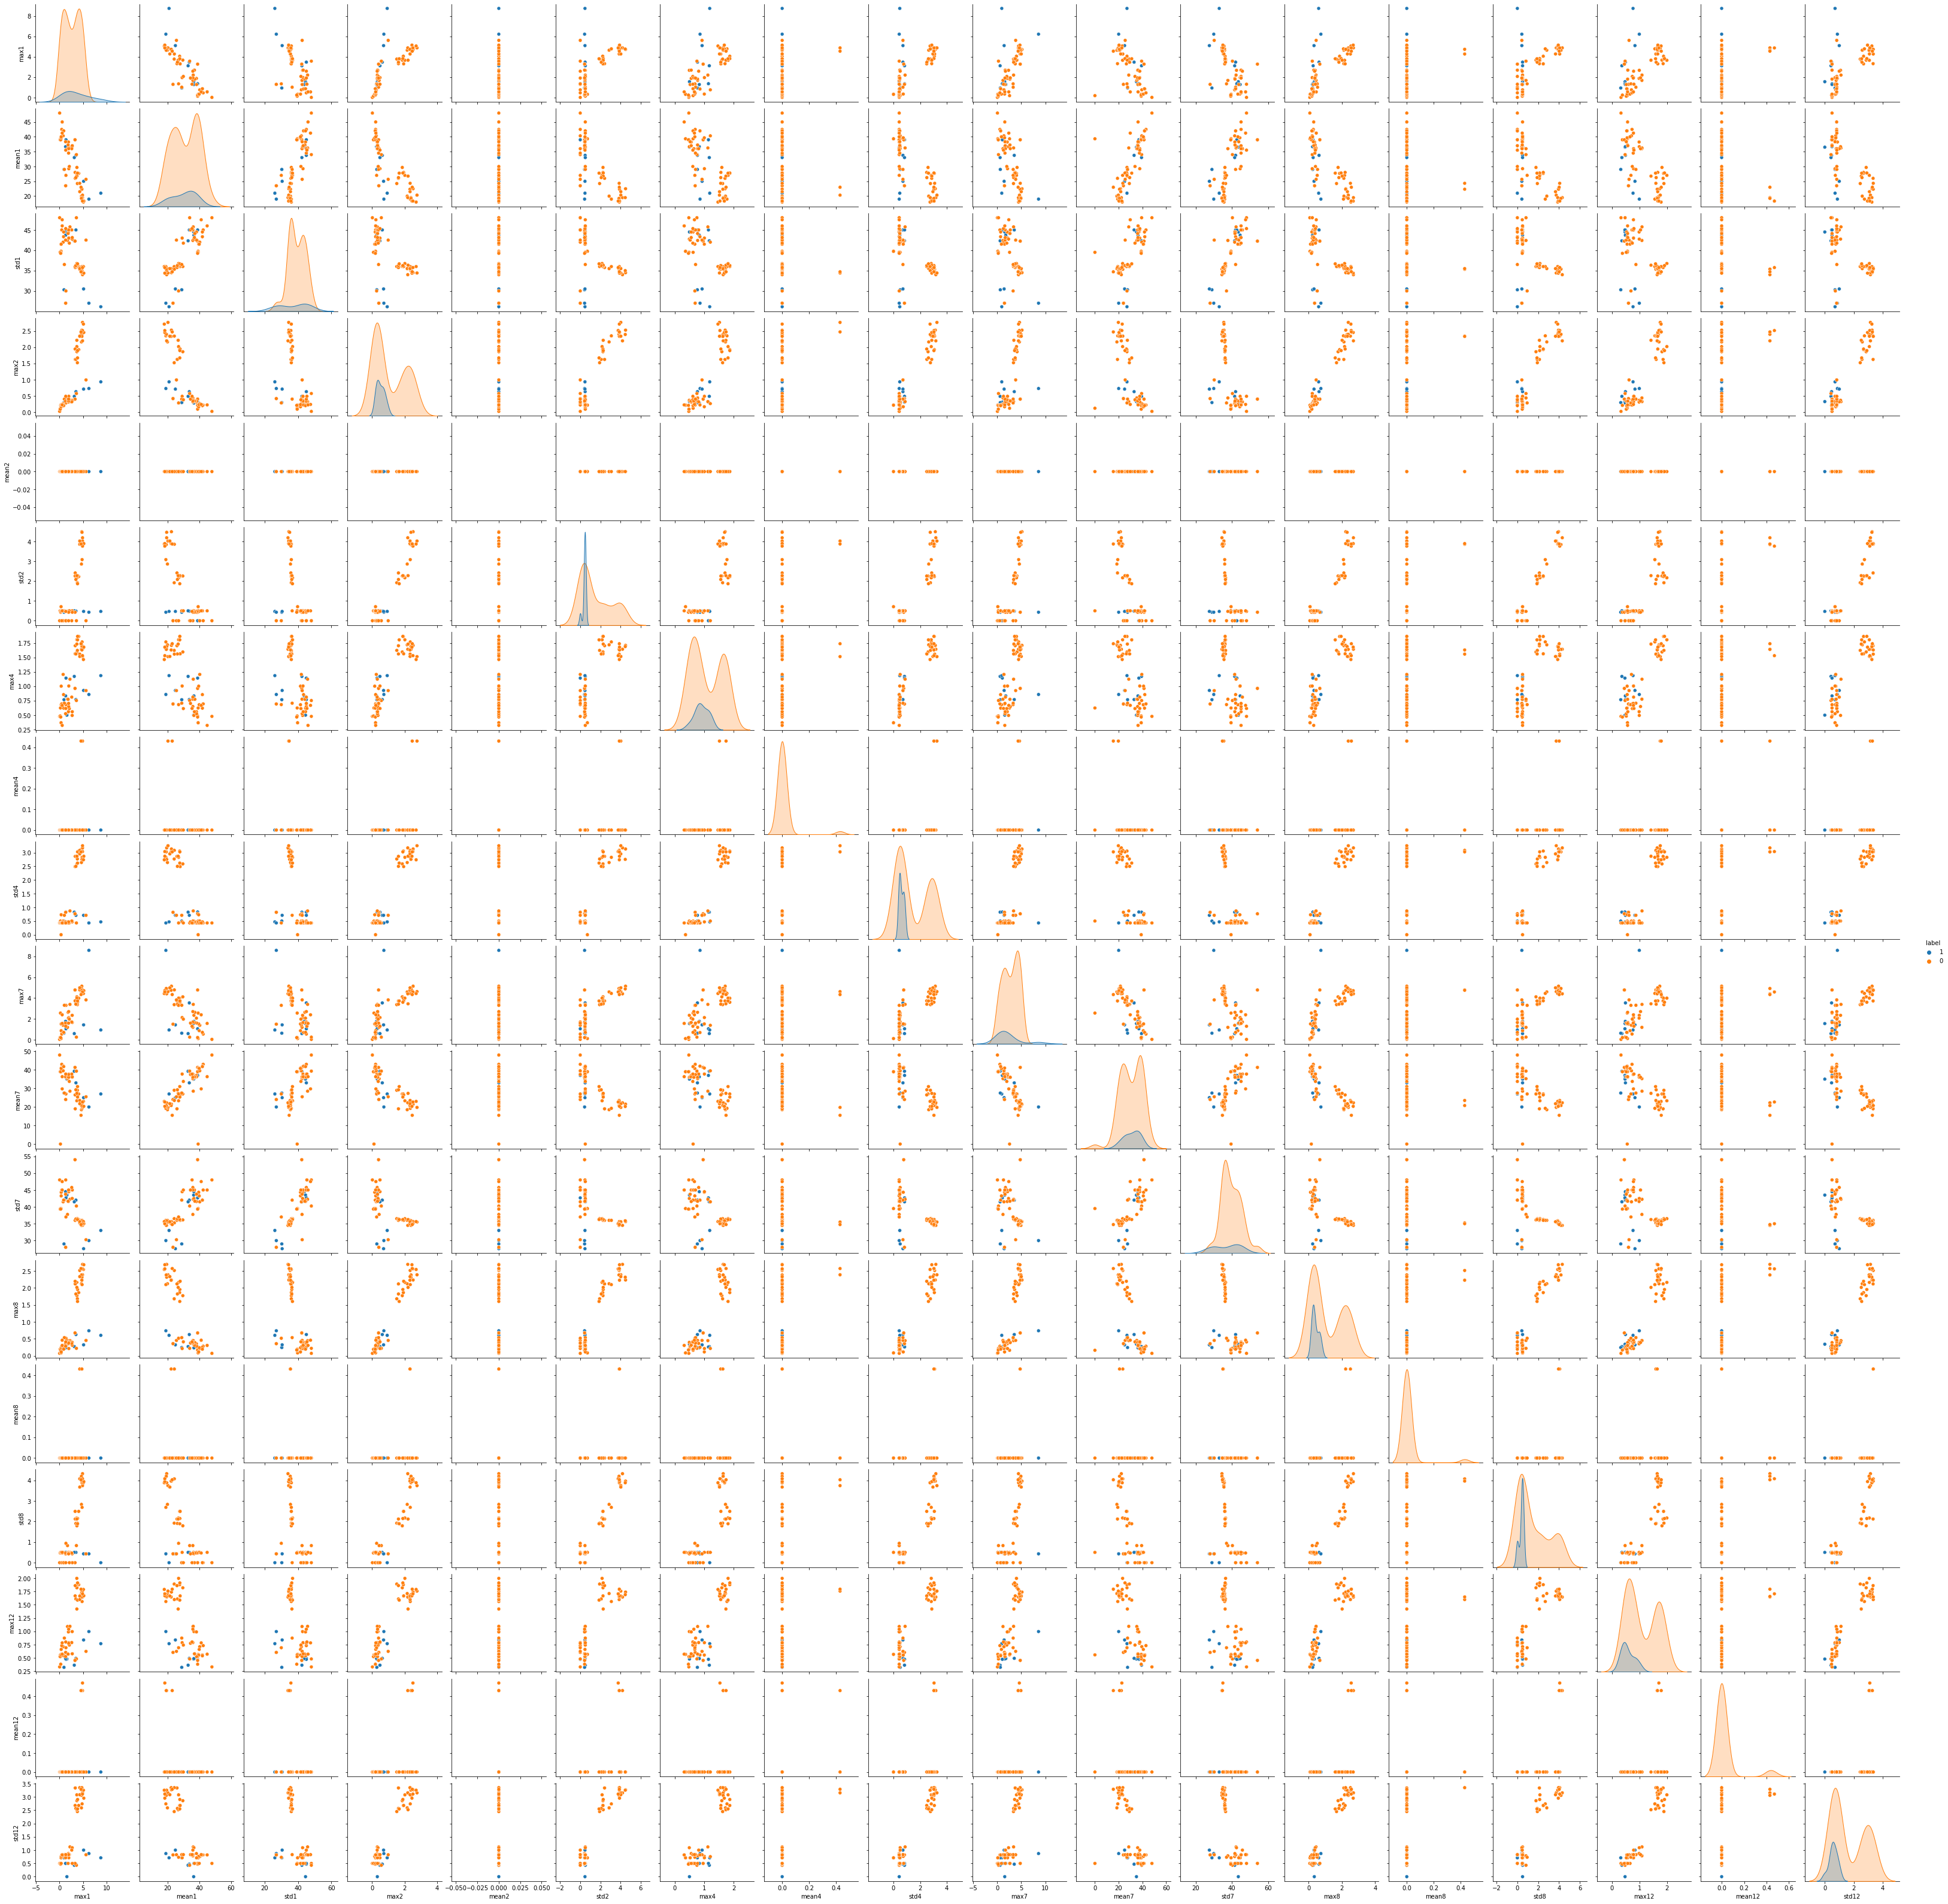

In [425]:
second_column = get_cols([1,2,4,7,8,12], ['max', 'mean', 'std'])
second_column_labeled_two = get_labeled_cols(train_data, second_column)
second_df_two = trained_df[second_column_labeled_two]
sns.pairplot(second_df_two, hue='label')
plt.show()

Observation: It's hard to tell whether there is a significant difference, further testing must be done.

# 2a.iii)

In [426]:
def get_features(stats, range_end):
    features = []
    for i in range(1, range_end):
        for stat in stats:
            features.append(f'{stat}{i}')
    return features

In [427]:
def update_label_new(df):
    df.loc[df['label'].str.contains('bending1|bending2'), 'label'] = 1
    df.loc[df['label'] != 1, 'label'] = 0
    return df

In [428]:
def oversample_data_set(data_set):
    print('Performing oversampling of dataset...')
    #print(data_set.loc[data_set['label'] == "0"].shape[1])
    #print(data_set['label'])
    label_0 = data_set.loc[data_set['label'] == 0].shape[0]
    label_1 = data_set.loc[data_set['label'] == 1].shape[0]
    #print(label_0)
    #print(label_1)
    minor_count = min(label_0, label_1)
    major_count = max(label_0, label_1)
    
    if label_0 > label_1:
        minor_label = 1
        major_label = 0
    else:
        minor_label = 0
        major_label = 1
        
    minor_ds = data_set[data_set['label'] == minor_label]
    major_ds = data_set[data_set['label'] == major_label]
    #print("before resample")
    #print(minor_ds)
    minor_ds_oversampled = resample(minor_ds, replace=True, random_state=60, n_samples=max(label_0, label_1))
    #print("after resample")
    print("oversample dataset")
    print(minor_ds_oversampled)
    print(major_ds)
    data_set = pd.concat([major_ds, minor_ds_oversampled])
    #print(data_set)
    return data_set


def oversample_class(train_df):
    total0 = train_df.loc[train_df['label'] == 0].shape[0]
    total1 = train_df.loc[train_df['label'] == 1].shape[0]
    minor_count = min(total0, total1)
    major_count = max(total0, total1)
    minor_label, major_label = (1, 0) if total0 > total1 else (0, 1)
        
    minor_ds = train_df[train_df['label'] == minor_label]
    major_ds = train_df[train_df['label'] == major_label]
    
    minor_ds = resample(minor_ds, replace = True, random_state = 60, n_samples = max(total0, total1))
    train_df = pd.concat([major_ds, minor_ds])
    train_df = train_df.dropna()
    train_df = train_df.replace([np.inf, -np.inf], np.nan)
    print("minor_count:", minor_count)
    print("major_count:", major_count)
    print("minor_label:", minor_label)
    print("major_label:", major_label)
    
    print("Number of 0 labels after oversampling:", train_df.loc[train_df['label'] == 0].shape[0])
    print("Number of 1 labels after oversampling:", train_df.loc[train_df['label'] == 1].shape[0])
    
    print("Sample row 1:", train_df.iloc[1])  # Inspect the first row
    print("Sample row 0:", train_df.iloc[0])  # Inspect the second row
    return train_df

def get_data(train_data, l, features, columns, selected_feature, is_binary = True):
    
    train_df = []
    for k, v in train_data.items():
        splits = np.array_split(v, l)
        temp = []
        for s in splits:
            stat = s.describe()
            for series in columns:
                for feature in selected_feature:
                    #print(series)
                    #print(stat[feature])
                    temp.append(stat[feature])
        temp.append(k)
        train_df.append(temp)
    #print(train_df)
    train_df = pd.DataFrame(train_df, columns = features)
    return train_df

def get_data_X_Y(data_set):
    #print(data_set)
    dataX = data_set.iloc[:, :-1]
    dataY = data_set.iloc[:, -1]
    #print("get data_x_y data for the unique labels")
    
    
    
    # Assuming one class label is 0 and the other is 1
    #dataY = dataY.map({'class_label_1': 1, 'class_label_2': 0})
    #print(dataY)
    return dataX, dataY

In [429]:
def logistic_regression(train_files, test_files, l_val, fold_count, oversample=False, penalty='none'):
    print(f'Running Logistic Regression for l-value {l_val}')
    features = get_features(ORDERED_STATS, 6 * l_val + 1)
    train_set = load_Data(train_files, features, OG_COLUMN_NAMES, segs=l_val)
    train_set = update_label_new(pd.DataFrame(train_set))
    
    if oversample:
        train_set = oversample_class(train_set)
    
    trainX, trainY = get_data_X_Y(train_set)
    
    trainX = trainX.dropna()
    trainX = trainX.replace([np.inf, -np.inf], np.nan)
    trainY = trainY.dropna()
    trainY = trainY.replace([np.inf, -np.inf], np.nan)
    
    print("Number of unique class labels in trainY:", len(trainY.unique()))
    print("Class labels in trainY:", trainY.unique())
    
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    
    #print("this is training X")
    #print(trainX)
    #print("this is training Y data")
    #print(trainY)
    selector.fit(trainX, trainY)
    return model, selector

In [430]:
cross_validation_factor = 5
L = 20
combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(train, test, l_val, cross_validation_factor, oversample=False)
    nf = selector.n_features_
    score = max(selector.grid_scores_)
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

#df = pd.DataFrame(combination)


Running Logistic Regression for l-value 1
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]
Running Logistic Regression for l-value 2
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]
Running Logistic Regression for l-value 3
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]
Running Logistic Regression for l-value 4
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]
Running Logistic Regression for l-value 5
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]
Running Logistic Regression for l-value 6
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]
Running Logistic Regression for l-value 7
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]
Running Logistic Regression for l-value 8
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]
Running Logistic Regression for l-value 9
Number of unique class labels in train

In [431]:
df = pd.DataFrame(combination)
df

,"pair(l, p)",score
0,"(1, 6)",1.0000
1,"(2, 2)",0.9714
2,"(3, 10)",0.9714
3,"(4, 1)",0.9714
4,"(5, 11)",0.9714
5,"(6, 5)",0.9857
6,"(7, 14)",0.9571
7,"(8, 26)",0.9571
8,"(9, 11)",0.9571
9,"(10, 20)",0.9571


The best pairs are (1,6), (13,12), (17,12) and (20,3). Further testing needs to be done to get a more accurate result. The correct way to do this test would be with RFE or Recursive Feature Elimination(RFE) with the cross validation.

# 2 a. iv)

In [432]:
def get_selected_features(features, selector):
    selected_features = []
    for i, feature in enumerate(features):
        if selector.support_[i]:
            selected_features.append(feature)
    return selected_features

In [433]:
l_value = 1
fold_count = 5
features = get_features(ORDERED_STATS, 6 * l_value + 1)
classifier, selector = logistic_regression(train, test, l_value, fold_count)
selected_features = get_selected_features(features, selector)
selected_features

Running Logistic Regression for l-value 1
Number of unique class labels in trainY: 2
Class labels in trainY: [1 0]


['min1', 'first_q1', 'third_q2', 'mean5', 'median5', 'third_q5']

In [434]:
train_set = load_Data(train, selected_features, OG_COLUMN_NAMES, segs=1)
train_set = update_label_new(pd.DataFrame(train_set))
trainX, trainY = get_data_X_Y(train_set)
df_temp = trainX.loc[:, selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype=float))
model = sm.Logit(trainY.to_numpy(dtype=float), const_val)
summary = model.fit(method='bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        23:24:55   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

In [435]:
def plot_roc_curve(actualY, predictedY_prob, classifier):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title("ROC curves")
    for i, classes in enumerate(classifier.classes_):
        y_predicted = predictedY_prob[:, i]
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted, pos_label=classes)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {classes}; ROC Curve Area: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

[[60  0]
 [ 0  9]]


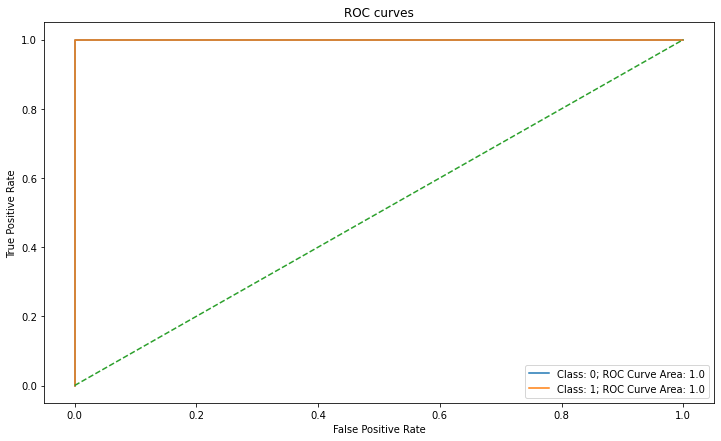

In [436]:
classification_and_roc_calculation(trainX, trainY, selected_features)

# v. Test Classifier

In [437]:
test_set = load_Data(test, selected_features, OG_COLUMN_NAMES, segs=1)
test_set = update_label_new(pd.DataFrame(test_set))
testX, testY = get_data_X_Y(test_set)

[[15  0]
 [ 0  4]]


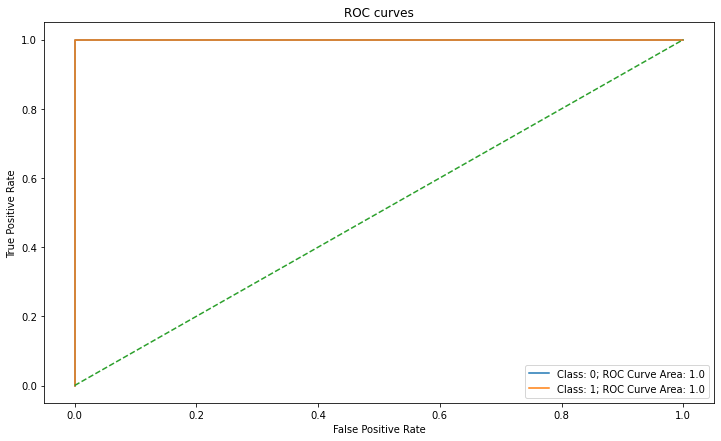

In [438]:
classification_and_roc_calculation(testX, testY, selected_features, isTest=True)

# 2a.vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Findings: The p-values suggests there is complete separation and that the Maximum Likelihood Estimator does not exist and thel the parameters are not always identified. Since the classes are well separated, it is causing the instability of calculation of the regression of the parameters.

 # 2a.vii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

There is definitely an imablance between the classes since ther are 69 instances of non-bending classes and 9 for bending classes which shows the disparity in the balance between the classes. As a result, oversampling will be necessary to help create a better regression model that fits with better sampling.

In [ ]:
# Logistic Regression with oversampling
print("Performing logistic regression with oversampling=True")
cross_validation_factor = 5
L = 20
combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(train, test, l_val, cross_validation_factor, oversample=True)
    nf = selector.n_features_
    score = max(selector.grid_scores_)
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

In [ ]:
l_value = 1
fold_count = 5
features = get_features(ORDERED_STATS, 6 * l_value + 1)
classifier, selector = logistic_regression(train, test, l_value, fold_count, oversample=True)
selected_features = get_selected_features(features, selector)
selected_features

In [ ]:
train_set = load_Data(train, selected_features, OG_COLUMN_NAMES, segs=1)
train_set = update_label_new(pd.DataFrame(train_set))
train_set = oversample_data_set(train_set)
trainX, trainY = get_data_X_Y(train_set)
classification_and_roc_calculation(trainX, trainY, selected_features)

In [ ]:
test_set = load_Data(test, selected_features, OG_COLUMN_NAMES, segs=1)
test_set = update_label_new(pd.DataFrame(test_set))
# test_set = oversample_data_set(test_set)
testX, testY = get_data_X_Y(test_set)
classification_and_roc_calculation(testX, testY, selected_features)

# 2b) Binary Classification Using L1-penalized logistic regression

2b-i) Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the textbook)

In [ ]:
max_test_accuracy = 0
opt_L_value = 1

In [ ]:
def perform_regression_with_classifier(classifier, classifier_name, l_val, kwargs, penalty='none', is_binary_classification=True, draw_roc=False):
    print(f'Running {classifier_name} for l-value {l_val}')
    features = get_features(ORDERED_STATS, 6 * l_val + 1)
    train_set = load_Data(train, features, OG_COLUMN_NAMES, segs=l_val)
    test_set = load_Data(test, features, OG_COLUMN_NAMES, segs=l_val)
    
    if is_binary_classification:
        train_set = update_label(pd.DataFrame(train_set))
        test_set = update_label(pd.DataFrame(test_set))
        
    trainX, trainY = get_data_X_Y(train_set)
    testX, testY = get_data_X_Y(test_set)
    
    if is_binary_classification:
        trainY = trainY.astype('int')
        testY = testY.astype('int')
    
    classifier2 = classifier(**kwargs)
    classifier2.fit(trainX, trainY)
    
    if not draw_roc:    
        train_score = round(classifier2.score(trainX, trainY), 4)
        test_score = round(classifier2.score(testX, testY), 4)
        print(f'Value of L: {l_val} | train_score: {train_score} | test_score: {test_score}')
        print(f'Value of L: {l_val} | train_error: {round((1 - train_score), 4)} | test_error: {round((1 - test_score), 4)}\n')
        global max_test_accuracy
        global opt_L_value
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            opt_L_value = l_val
        if l_val == 20:
                print('\n')
                print(f'The maximum accuracy is {max_test_accuracy} (for L-value: {opt_L_value})')
                print(f'Further calculations will be done with L-value: {opt_L_value}')
        
    else:
        train_predictY_prob = classifier2.predict_proba(trainX)
        test_predictY_prob = classifier2.predict_proba(testX)

        predictY = classifier2.predict(testX)
        cm = confusion_matrix(testY, predictY)
        print(f"Confusion matrix for test data:\n{cm}")
        
        print("ROC Curve for Train Data")
        plot_roc_curve(trainY, train_predictY_prob, classifier2)
        
        print("ROC Curve for Test Data")
        plot_roc_curve(testY, test_predictY_prob, classifier2)

In [ ]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

fold_count = 5
for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV,
                                       "Logistic Regression", 
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=True, 
                                       draw_roc=False)

Maximum accuracy will be done with 1.0 with L-value of 1.

In [ ]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

fold_count = 5
best_l = 1

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(LogisticRegression,
                                   "Logistic Regression",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=True, 
                                   draw_roc=True)

# 2b-ii) Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

Observations: L1 penalized logistic regression is better in terms of accuracy and is better for performance. The L1 regularization is also easier to implement since there does not need to be much pre-processing done beforehand. The feature selection is also not as intensive.

# 2c) Multi-class Classification (The Realistic Case)

# 2ci)

In [ ]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 10000,
    'multi_class': 'multinomial',
    'cv': 5,
    'random_state' : 69,
    'solver' : 'saga'
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV, 
                                       "Logistic Regression",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

Do more calculations with l-value of 2.

In [ ]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 10000, 
    'multi_class' : 'multinomial',
    'solver' : 'saga'
}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(LogisticRegression, 
                                   "Logistic Regression",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

The curves under the area shows that there is a disparity in locating some of the true positives for the different datasets. The test data especially shows a discrepancy in the model. However, the area under the ROC is still pretty high for all of the datasets in the class.

# 2c-ii) Repeat 2(c)i using Naive Bayes

In [ ]:
kwargs = {}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_regression_with_classifier(GaussianNB, 
                                       "Naive Bayes Classifier with Gaussian Prior",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

In [ ]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(GaussianNB, 
                                   "Naive Bayes Classifier with Gaussian Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

In [ ]:
kwargs = {
    
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

for l_val in range(1, 21):
    perform_regression_with_classifier(MultinomialNB, 
                                       "Naive Bayes Classifier with Multinomial Prior",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

In [ ]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

perform_regression_with_classifier(MultinomialNB, 
                                   "Naive Bayes Classifier with Multinomial Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

# 2ciii)

The area under ROC is better for Logistic Regression than other classifiers so it is the best classification compared to the other methods for this particular dataset. According to the No Free Lunch Theorem, this does not mean Logistic Regression is always good- it is just specific to this particular dataset.

# ISLR 4.8.3

This problem relates to the QDA model, in which the observations
within each class are drawn from a normal distribution with a classspecific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.
Suppose that we have K classes, and that if an observation belongs
to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(µk, σ2
k). Recall that the density function for the
one-dimensional normal distribution is given in (4.16). Prove that in
this case, the Bayes classifier is not linear. Argue that it is in fact
quadratic.
Hint: For this problem, you should follow the arguments laid out in
Section 4.4.1, but without making the assumption that σ2
1 = ... = σ2
K.

To argue that the Bayes classifier is linear: you can use the posterior probability function discussed in class:
 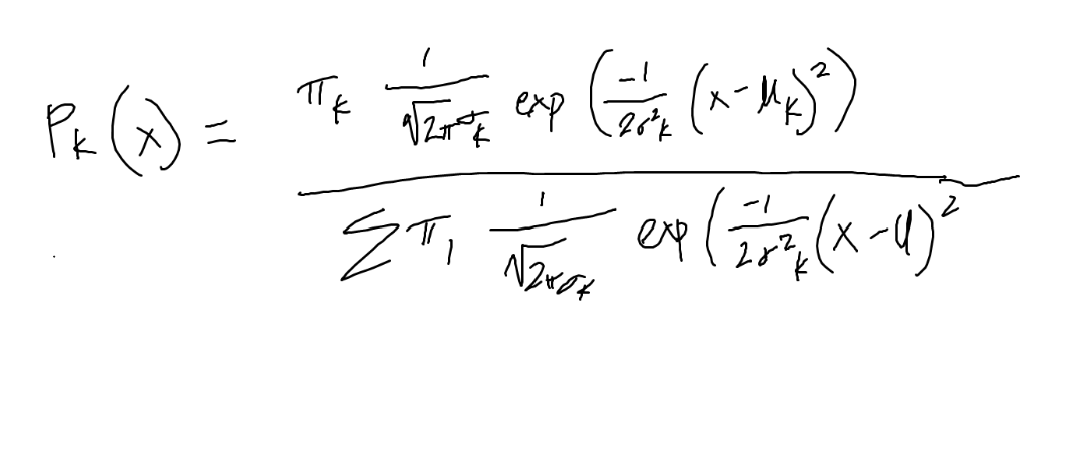

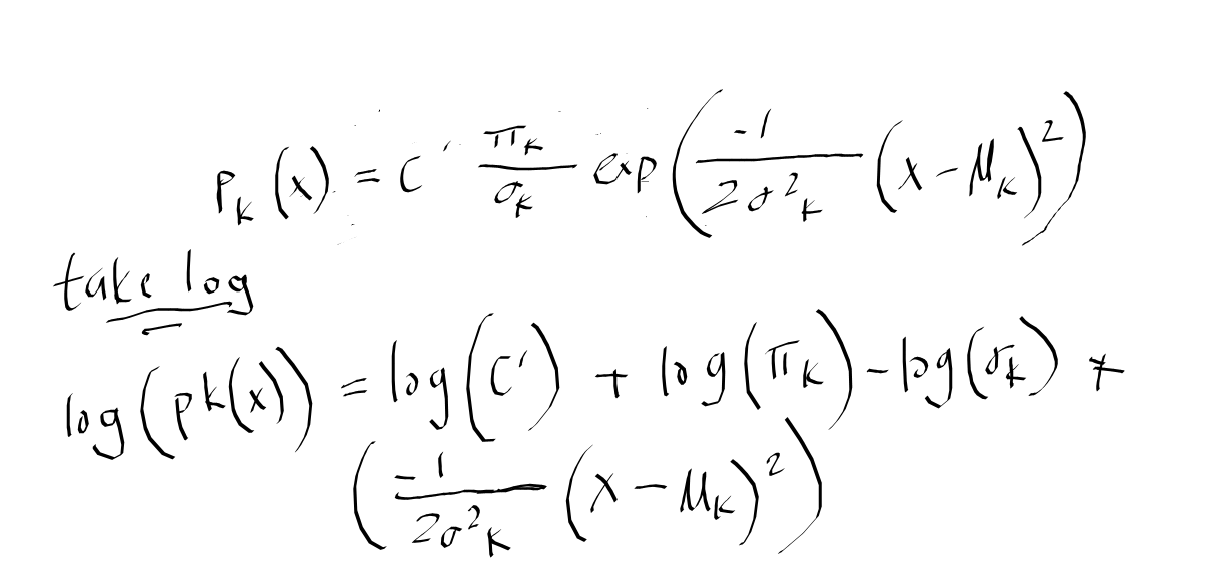

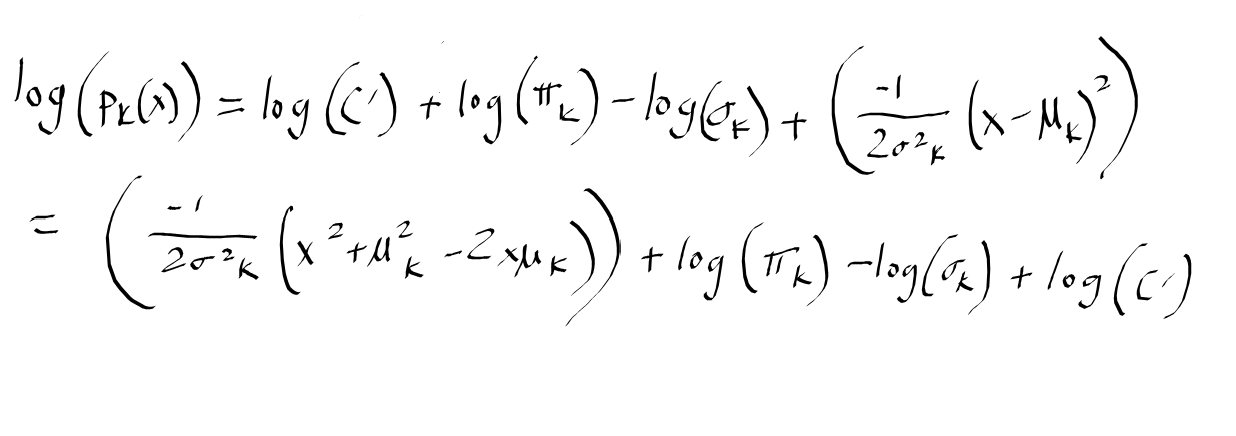

The function seems to be quadratic so the Bayes' classifier is not linear.

# ISLR 4.8.7

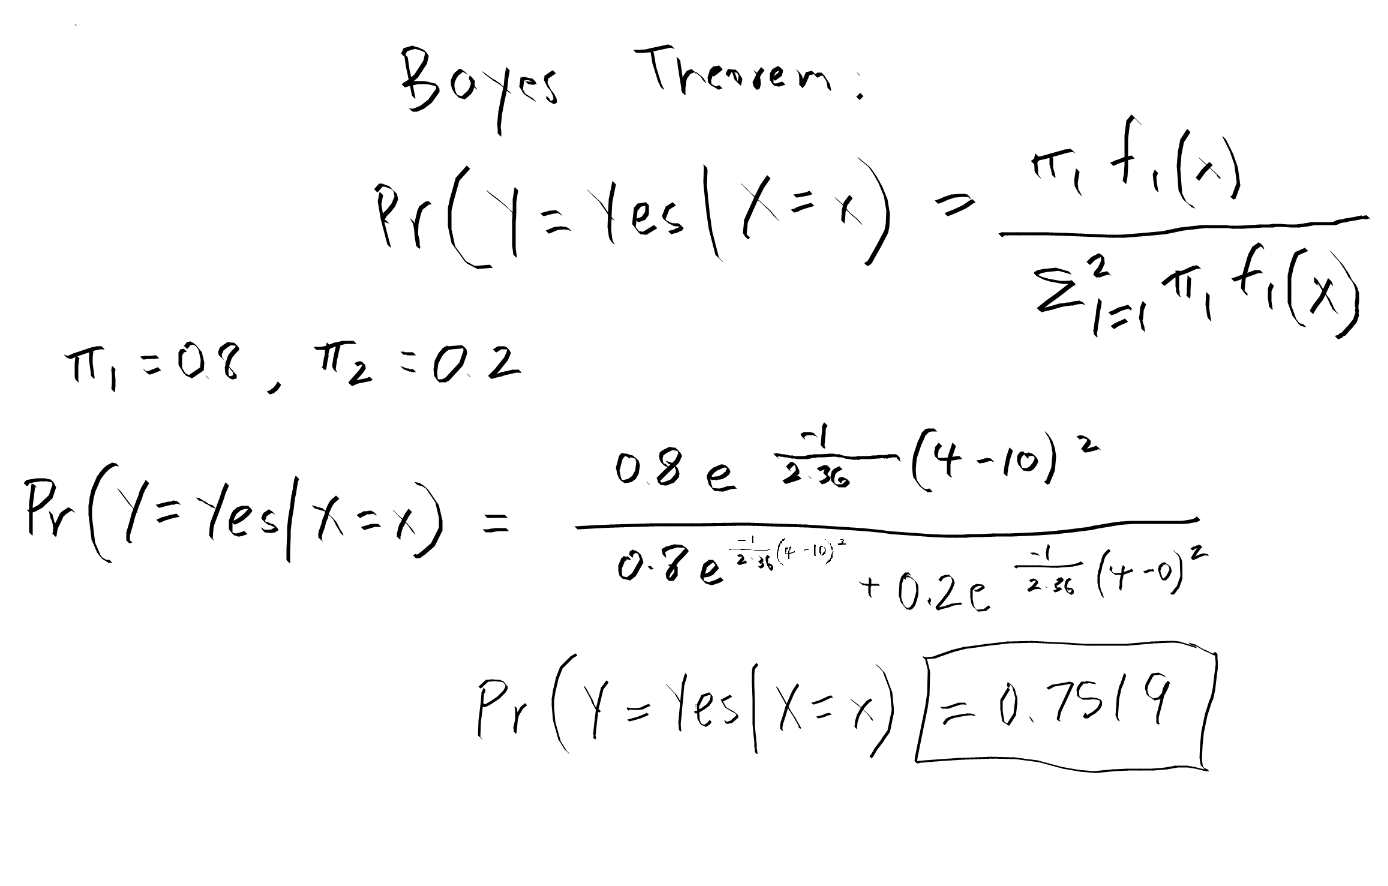